Global seed set to 42


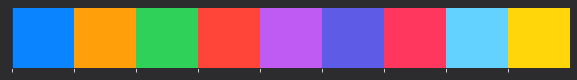

In [1]:
import time
import logging
import os
import glob
import json
import re
import random
import textwrap
from termcolor import colored
from pathlib import Path
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
import plotly.graph_objects as go
import plotly.express as px
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import pytorch_lightning as pl

tqdm.pandas()

pl.seed_everything(42)

%matplotlib inline

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]
raw_darks=[
    (44, 44, 46)
]
raw_lights=[
    (229, 229, 234)
]
miscellaneous={
    'blue':'#0f71d4',
    'green':'#14b827',
    'red':'#cf0c0c'
}

dark_palette=np.array(raw_dark_palette)/255
darks=np.array(raw_darks)/255
lights=np.array(raw_lights)/255

#rcparams
dark_color=darks[-1]
light_color=lights[-1]

mpl.rcParams['axes.prop_cycle']=cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']=dark_color
mpl.rcParams['figure.edgecolor']=dark_color
mpl.rcParams['axes.facecolor']=dark_color
mpl.rcParams['text.color']=light_color
mpl.rcParams['axes.labelcolor']=light_color
mpl.rcParams['axes.edgecolor']=dark_color
mpl.rcParams['xtick.color']=light_color
mpl.rcParams['ytick.color']=light_color
mpl.rcParams['figure.dpi']=80
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

sns.palplot(dark_palette)

In [2]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [15]:
data_dir='data/Binance_BTCUSDT_minute.csv'
df=pd.read_csv(data_dir,parse_dates=['date'],header=1)
df=df.sort_values(by='date').reset_index(drop=True)
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1567965420000,2019-09-08 17:57:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1
1,1567965480000,2019-09-08 17:58:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0
2,1567965540000,2019-09-08 17:59:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1
3,1567965600000,2019-09-08 18:00:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0
4,1567965660000,2019-09-08 18:01:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0


In [17]:
df.shape

(924212, 10)

# Preprocessing

In [18]:
df["prev_close"]=df.shift(1)['close']
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,prev_close
0,1567965420000,2019-09-08 17:57:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1,NaN
1,1567965480000,2019-09-08 17:58:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0,10000.0
2,1567965540000,2019-09-08 17:59:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1,10000.0
3,1567965600000,2019-09-08 18:00:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0,10000.0
4,1567965660000,2019-09-08 18:01:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0,10000.0


In [21]:
df['close_changed']=df.progress_apply(lambda row: 0 if np.isnan(row.prev_close) else row.close-row.prev_close,axis=1)
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,prev_close,close_changed
0,1567965420000,2019-09-08 17:57:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1,NaN,0.0
1,1567965480000,2019-09-08 17:58:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0,10000.0,0.0
2,1567965540000,2019-09-08 17:59:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1,10000.0,0.0
3,1567965600000,2019-09-08 18:00:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0,10000.0,0.0
4,1567965660000,2019-09-08 18:01:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0,10000.0,0.0


In [23]:
df.describe()

,unix,open,high,low,close,Volume BTC,Volume USDT,tradecount,prev_close,close_changed
count,9.242120e+05,924212.000000,924212.000000,924212.000000,924212.000000,924212.000000,9.242120e+05,924212.000000,924211.000000,924212.000000
mean,1.595707e+12,19635.217125,19650.276044,19620.103511,19635.258228,108.146967,1.572492e+06,754.922705,19635.235910,0.032743
std,1.603116e+10,16992.796432,17008.824518,16976.845388,16992.814043,241.842601,2.699351e+06,988.913337,16992.809691,36.372013
min,1.567965e+12,3706.960000,3779.000000,3621.810000,3706.960000,0.000000,0.000000e+00,0.000000,3706.960000,-4745.730000
25%,1.581829e+12,8728.685000,8732.660000,8724.730000,8728.715000,25.653368,3.468851e+05,166.000000,8728.710000,-4.920000
50%,1.595692e+12,10276.220000,10280.005000,10272.030000,10276.240000,50.510307,8.527767e+05,454.000000,10276.230000,0.000000
75%,1.609576e+12,29644.300000,29681.227500,29589.225000,29644.307500,108.048279,1.819462e+06,1020.000000,29642.615000,4.920000
max,1.623719e+12,64800.000000,64854.000000,64685.170000,64800.000000,14204.567000,1.609358e+08,31712.000000,64800.000000,1548.890000


In [25]:
rows=list()
for idx,row in tqdm(df.iterrows(),total=df.shape[0]):
    data=dict(
        day_of_week=row.date.dayofweek,
        day_of_month=row.date.day,
        week_of_year=row.date.week,
        month=row.date.month,
        open=row.open,
        high=row.high,
        low=row.low,
        close_chane=row.close_changed,
        close=row.close
    )
    rows.append(data)
df2=pd.DataFrame(rows)

In [36]:
df2.rename(columns={'close_chane':'close_change'},inplace=True)

In [37]:
df2.head()

,day_of_week,day_of_month,week_of_year,month,open,high,low,close_change,close
0,6,8,36,9,10000.0,10000.0,10000.0,0.0,10000.0
1,6,8,36,9,10000.0,10000.0,10000.0,0.0,10000.0
2,6,8,36,9,10000.0,10000.0,10000.0,0.0,10000.0
3,6,8,36,9,10000.0,10000.0,10000.0,0.0,10000.0
4,6,8,36,9,10000.0,10000.0,10000.0,0.0,10000.0


In [3]:
df2.to_csv('dataset/feature_df.csv')

NameError: name 'df2' is not defined

In [4]:
df2=pd.read_csv('dataset/feature_df.csv')
df2.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
train_df,test_df=train_test_split(df2,test_size=0.1,shuffle=False)

In [6]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_df)
train_df=pd.DataFrame(scaler.transform(train_df),index=train_df.index,columns=train_df.columns)
test_df=pd.DataFrame(scaler.transform(test_df),index=test_df.index,columns=test_df.columns)

In [13]:
train_df.head()

,day_of_week,day_of_month,week_of_year,month,open,high,low,close_change,close
0,1.0,-0.533333,0.346154,0.454545,-0.783346,-0.785723,-0.780519,0.242895,-0.783389
1,1.0,-0.533333,0.346154,0.454545,-0.783346,-0.785723,-0.780519,0.242895,-0.783389
2,1.0,-0.533333,0.346154,0.454545,-0.783346,-0.785723,-0.780519,0.242895,-0.783389
3,1.0,-0.533333,0.346154,0.454545,-0.783346,-0.785723,-0.780519,0.242895,-0.783389
4,1.0,-0.533333,0.346154,0.454545,-0.783346,-0.785723,-0.780519,0.242895,-0.783389


In [7]:
def create_sequence(data,target,sequence_length):
    sequences=list()
    data_size=len(data)
    for i in tqdm(range(data_size-sequence_length)):
        sequence=data[i:i+sequence_length]
        label=data.iloc[i+sequence_length][target]
        sequences.append((sequence,label))
    return sequences

In [8]:
SEQUENCE_LENGTH=120
train_sequences=create_sequence(train_df,'close',SEQUENCE_LENGTH)
test_sequences=create_sequence(test_df,'close',SEQUENCE_LENGTH)

# Pytorch Dataset

In [9]:
class BTC_Dataset(Dataset):

    def __init__(self,sequences):
        self.sequences=sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        sequence,label=self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label=torch.tensor(label).float()
        )
    

In [10]:
class BTC_DataModule(pl.LightningDataModule):

    def __init__(self,train_sequences,test_sequences,batch_size=4):
        super().__init__()
        self.train_sequences=train_sequences
        self.test_sequences=test_sequences
        self.batch_size=batch_size
    
    def setup(self):
        self.train_df=BTC_Dataset(self.train_sequences)
        self.test_df=BTC_Dataset(self.test_sequences)
    
    def train_dataloader(self):
        return DataLoader(self.train_df,batch_size=self.batch_size,shuffle=False)
    
    def val_dataloader(self):
        return DataLoader(self.test_df,batch_size=1,shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.test_df,batch_size=1,shuffle=False)


In [11]:
EPOCHS=5
BATCH_SIZE=32

data_module=BTC_DataModule(train_sequences,test_sequences,BATCH_SIZE)
data_module.setup()

In [12]:
class BTCPricePredictionModel(nn.Module):

    def __init__(self,n_features,n_hidden=128,n_layers=2):
        super().__init__()
        self.n_hidden=n_hidden
        self.lstm=nn.LSTM(n_features,n_hidden,n_layers,batch_first=True,dropout=0.2)
        self.out=nn.Linear(n_hidden,1)
    
    def forward(self,x):
        self.lstm.flatten_parameters()
        _,(hidden,_)=self.lstm(x)
        out=hidden[-1]
        return self.out(out)

In [13]:
class BTCModule(pl.LightningModule):

    def __init__(self,n_features,n_hidden=128,n_layers=2):
        super().__init__()
        self.model=BTCPricePredictionModel(n_features,n_hidden,n_layers)
        self.criterion=nn.MSELoss()

    def forward(self,x,labels=None):
        output=self.model(x)
        loss=0
        if labels is not None:
            loss=self.criterion(output,labels.unsqueeze(dim=1))
        return loss,output
    
    def training_step(self,batch,batch_idx):
        sequences=batch['sequence']
        labels=batch['label']
        loss,output=self(sequences,labels)
        self.log('train_loss',loss,prog_bar=True,logger=True)
        return loss

    def validation_step(self,batch,batch_idx):
        sequences=batch['sequence']
        labels=batch['label']
        loss,output=self(sequences,labels)
        self.log('val_loss',loss,prog_bar=True,logger=True)
        return loss

    def test_step(self,batch,batch_idx):
        sequences=batch['sequence']
        labels=batch['label']
        loss,output=self(sequences,labels)
        self.log('test_loss',loss,prog_bar=True,logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(),lr=0.0001)

    def configure_callbacks(self):
        model_checkpoint=pl.callbacks.ModelCheckpoint('models','model1.ckpt','val_loss')
        return [model_checkpoint]

In [14]:
model=BTCModule(n_features=train_df.shape[1])

In [17]:
print(model.metrics)

AttributeError: 'BTCModule' object has no attribute 'metrics'

In [15]:
trainer=pl.Trainer(max_epochs=EPOCHS,gpus=1,progress_bar_refresh_rate=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [16]:
trainer.fit(model,data_module)

F:\anacondapython\envs\tf\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                    | Params
------------------------------------------------------
0 | model     | BTCPricePredictionModel | 203 K 
1 | criterion | MSELoss                 | 0     
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.814     Total estimated model params size (MB)
Epoch 0:   0%|          | 0/25990 [00:00<?, ?it/s] F:\anacondapython\envs\tf\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many worke

MisconfigurationException: ModelCheckpoint(monitor='val_loss') not found in the returned metrics: ['train_loss']. HINT: Did you call self.log('val_loss', value) in the LightningModule?